# Caution! Pandas can be dangerous too
### Import pandas as pd !!! but wait ....

![](images/angry_panda.jpg)

I have been working with Pandas for a long time and I really like how it simplifies most of data explorations and cleaning processes. It has been "almost" always fun using various methods of python for discovery analysis or product/pipeline development, such as read_csv(), describe(), merge(), concat(), query(), join(), "even" reset_index() ... you name it!!

However, there have been two times in my career, so far, that angry Pandas really caught me off guarded! Yes, Pandas sometimes get angry!! 

**TL:DR if you are dealing with fairly large datasets or medium dataset (like 10k) within a lot of loops, it would definitely be worth the trouble to predefine the array size or use `list` data structure instead of pandas DataFrame or numpy arrays!!**

Ok, let's start by importing the packages and creating a simple reproducible table. Please feel free to pull this notebook from my githib repo. As to have a reproducible example, 

In [64]:
import random, string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

The goal of this project is creating a dataframe with two columns amd 10,000 rows and append one of the columns of the dataframe as a new column 1000 times. So the final table would have 10,000 rows and 1002 columns including 2 initital plus 1000 new columns.

I am defining two handler functions that will be used in the notebook. The first function is `create_alpha_numeric` that generates a string of alphabets + numerics with a specific length. the second function takes a list and returns its transpose using python built-in functions list(), map() and zip(). 

In [10]:
def create_alpha_numeric(length = 16):
    """Creates alpha numeric string with a specific length
    Args:
        length <int> length of alphanumeric string
    Output
        alpha_num <string> string of "length" including alphabets and numerics (e.g. oZMfuT4n2xDglTMJ)
    """
    alpha_num = ''.join(random.choice(string.ascii_uppercase + string.ascii_lowercase + string.digits) for _ in range(length))
    return alpha_num

def transpose_list(object_list):
    """Transposes the list of objects using python functions of map and zip
    Args:
        object_list <list> list of objects
    Output:
        transposed_list <list> transpose of the list
    """
    transposed_list = list(map(list, zip(*new_df)))
    return transposed_list

the initital dataframe (df) has two columns and maximum of 10,000 rows. The first column is the ID of the item (alphanumeric) and the second row are random numbers between 5 and 1000. The probability of observing two identical 16-character string is very small but we set the dataframe to have the unique number of those Ids.

In [22]:
df_size = 10000

items = set()
for i in range(df_size):
    items.add(create_alpha_numeric())
    
weights = np.random.randint(5, 1000, len(items))
df = pd.DataFrame({'Item': list(items), 'Weight': weights})

display(df.head())

,Item,Weight
0,w9bl409LHs8u0fS9,161
1,aABdf4itejZhEKxi,376
2,XOQDjtudpl1dhRZF,87
3,dYFTCnTuLG6TnN8z,457
4,DRalbm4ANSiwgk8z,472


Let's add the Weight column to the DataFrame `df` 1000 times. For this purpose, I will use pandas concat() method to append new columns to the current dataframe. This is not an efficient way and if you run the cell below, you will notice that the iteration speed reduces exponentially. The main reason is that pd.concat returns a new DataFrame in each iteration. Space is being allocated for the new DataFrame  and the data from the old DataFrames is being copied into the new DataFrame. 

![](images/concat_example.png)

The best example I can think of is: imagine you would like to add new brick to the top of a wall. with pandas, instead of putting a brick on top of that wall, you create a new wall with the same number of bricks in a different location (memory) and then add that brick to the top of the new wall. Suppose, you are going to do it for 1000 times. Such a waste of bricks, location and energy, right!! 

In [92]:
iter_size = 1000
new_df = df
for i in tqdm(range(iter_size)):
    new_df = pd.concat([new_df, df.Weight], axis = 1)

100%|██████████| 1000/1000 [01:16<00:00, 13.10it/s]


Alright, it took about 76 seconds to run the 1000 iteration and append the second column to the pandas dataframe. now let's implement the same dataframe using `np.concatenate()` method and see if we are observing any improvement. Note that the `.values` attribute of a pandas series is a row array. so we need to reshape it to a column array to be able to concatenate to the 2d array.

In [94]:
new_df = df
for i in tqdm(range(iter_size)):
    new_df = np.concatenate([new_df, df.Weight.values.reshape(-1, 1)], axis = 1)

100%|██████████| 1000/1000 [01:09<00:00, 14.31it/s]


The `np.concatenate` implementation succeeded in 69 seconds which is a little bit faster than the pandas implementation but still not super fast and tracking the memory usage shows that it is not very memory efficient. It seems like similar memory allocation and numpy array data transfer is happening when we are using np.concatenate. Which makes sense as we are not telling the program what size it would expect from our script. I will use two other implementations where we can improve the memory allocation and execution speed. First method is using build-in python functions and the second one is using numpy arrays but specifying the array size beforehand. 

#### Python built-in functions:

In the cell below, I am applying `map()` and `zip()` functions to transpose the array and then append the list to the current list. This is helpful if you are familiar with built-in functions and you do not know the size of the final output.

In [41]:
new_df = df.values.tolist()
new_df = np.array(new_df).T.tolist()
for i in tqdm(range(1000)):
    new_df.append(df.Weight.values.tolist())
# new_df = pd.DataFrame(np.array(new_df).T)

100%|██████████| 1000/1000 [00:00<00:00, 2031.29it/s]


Wow, the for loop took less than a second with 2289 iterations per second!! so more than x70 improvement in execution time by switching from concatenating with pandas and numpy to single list append. The last implementation would be using numpy but allocating the size of the array before for loop/

#### numpy array with predefined array size

If you are a great fan of numpy abstractions, the good news is you can still improve memory allocation and execution speed by pre-defining the np array size before for loops. Please take a look at the cell below where I created an array of zeros and populate the elements with the columns. very similar performance to the python buit-in function implementation.

In [31]:
new_df = np.zeros((len(items), iter_size + df.shape[1]))
for i in tqdm(range(iter_size)):
    new_df[:, i + df.shape[1]] = df.Weight.values

100%|██████████| 1000/1000 [00:00<00:00, 3496.88it/s]


### Simulate four methods

Well, if you are a scientist or statistician, you might not accept a hypothesis using only one data points. Variation and uncertainty are the other aspect of the data that affects the validity of the data at hand. For this purposes, I ran all those implementations 20 times on my macbook with `2.7 GHz Dual-Core Intel Core i5` processor and `8 GB 1867 MHz DDR3` memeory and recorded the execution time. Here are the codes to run if you would like to explore more. Just run `python simulate_execution.py <SIMULATION_NUMBER>`. Below is the violin plot that depicts both execution time variation and density function.

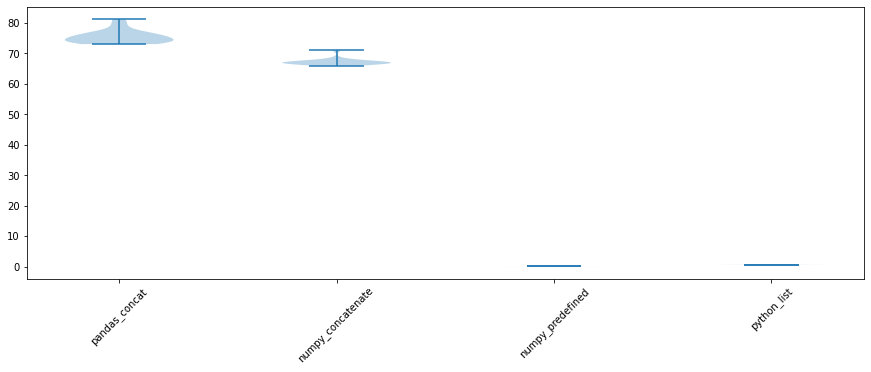

In [100]:
execution_time = pd.read_csv('images/execution_time_20.csv')
plt.figure(figsize = (15, 5))
plt.violinplot(dataset = execution_time)
plt.xticks(ticks = [1, 2, 3, 4], labels = execution_time.columns, rotation = 45)
plt.show()

due to the difference in the execution time of the four implementation, I am plotting the two super fast implementation in case someone is interested in those. It seems like predefining the array size before hand would speed up the process a little bit more. But we all know that it is not always possible to know the output size before hand. In those case, you would be better off using builtin function rather than applying pandas or numpy methods. 

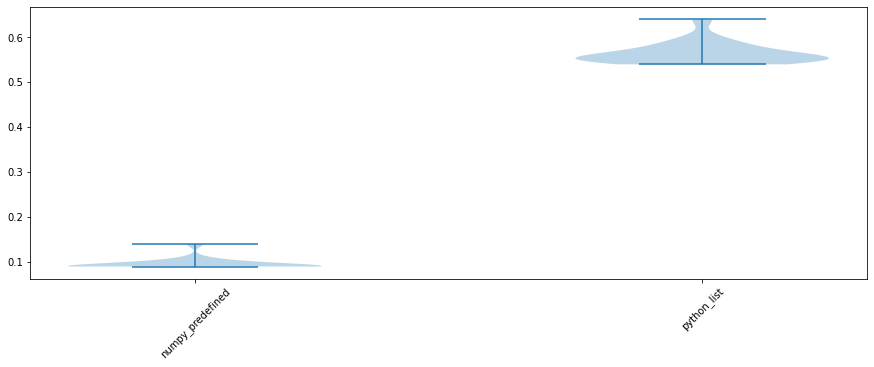

In [101]:
plt.figure(figsize = (15, 5))
plt.violinplot(dataset = execution_time.iloc[:, 2:])
plt.xticks(ticks = [1, 2], labels = execution_time.columns[2:], rotation = 45)
plt.show()

Hope this "slightly" short notebook could help you with writing more efficient and faster programs and prevent you from hours of debugging memory allocation issues (as I encountered two times). I will do my best to share more hints as I come across blockers during my careers. Please follow my [twitter](https://twitter.com/EhsanJahanpour) and lets keep in touch.